# Time-weighted averages

This notebook provides two simple examples to explain the concept of **time-weighted averages**.

These are then related back to the model, with the concept of the "**area under the curve**" and some exercepts from the model code.

The **utilisation** metrics in the model are then compared - the time-weighted utilisation, alongside two others - explaining their calculations, purposes, pros and cons.

In [1]:
# pylint: disable=missing-module-docstring
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

pio.renderers.default = 'svg'

In [2]:
# Start time
start_time = datetime.now()

## Example 1: Queue size

Here we have a given queue size over time:

| Interval    | Queue Size | Duration |
|-------------|------------|----------|
| 0 - 14.4    | 0          | 14.4     |
| 14.4 - 15.2 | 1          | 0.8      |
| 15.2 - 16.1 | 2          | 0.9      |
| 16.1 - 17.0 | 3          | 0.9      |

You can see that, for most of the time, there is no-one in the queue, but then a few people join at the end.

Hence, we would logically expect to see an average queue size fairly close to 0.

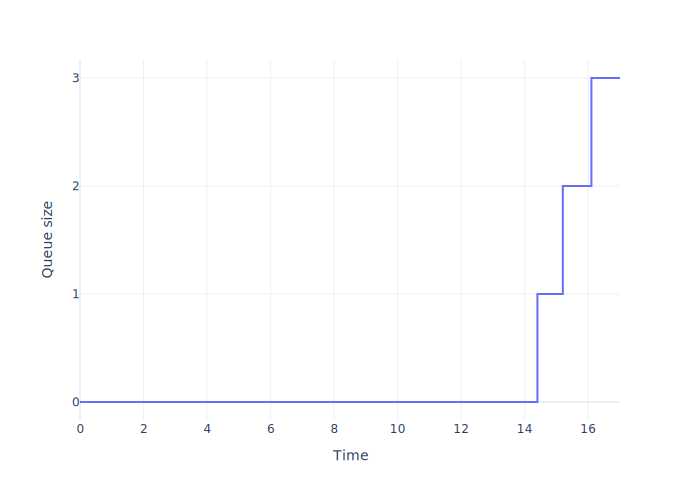

In [3]:
# Given data
time = [0.0, 14.4, 15.2, 16.1, 17.0]
queue = [0, 1, 2, 3, 3]

fig = px.line(x=time, y=queue)
fig.update_traces(mode='lines', line_shape='hv')
fig.update_xaxes(dtick=2)
fig.update_yaxes(dtick=1)
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Queue size',
    template='plotly_white')
fig.show()

### Simple average

#### Formula for simple average queue size:

$$
\text{Simple Average} = \frac{\sum (\text{Queue Size})}{\text{Number of Intervals}}
$$

#### Applying values:

$$
= \frac{0 + 1 + 2 + 3}{4}
$$

$$
= \frac{6}{4} = 1.5
$$

With a simple average, we find quite a high average: 1.5.

In [4]:
simple_avg = sum(queue[:-1]) / len(queue[:-1])
print(f'Simple Average Queue Size: {simple_avg}')

Simple Average Queue Size: 1.5


### Time-weighted average

#### Formula for time-weighted average queue size:

$$
\text{Time-Weighted Average} = \frac{\sum (\text{Queue Size} \times \text{Time Duration})}{\text{Total Time}}
$$

#### Applying values:

$$
= \frac{(0 \times 14.4) + (1 \times 0.8) + (2 \times 0.9) + (3 \times 0.9)}{17.0}
$$

$$
= \frac{0 + 0.8 + 1.8 + 2.7}{17.0}
$$

$$
= \frac{5.3}{17.0} \approx 0.312
$$

The time-weighted average better meets our expectations, being fairly close to 0.

In [5]:
# Compute time-weighted sum
weighted_sum = sum(
    queue[i] * (time[i+1] - time[i]) for i in range(len(time)-1))

# Total time duration
# pylint:disable=invalid-name
total_time = time[-1] - time[0]

# Compute time-weighted average
time_weighted_avg = weighted_sum / total_time

print(f'Time-Weighted Average Queue Size: {time_weighted_avg}')

Time-Weighted Average Queue Size: 0.3117647058823529


### Relating this back to the model code

In `model.py`, the queue length is recorded during the simulation using:

```{python}
# Add "area under curve" of people in queue
# len(self.queue) is the number of requests queued
self.area_n_in_queue.append(len(self.queue) * time_since_last_event)
```

At the end, this is used to calculate the time-weighted average queue length using:

```{python}
'mean_nurse_q_length': (
     model.nurse.area_n_in_queue /
     self.param.data_collection_period)
```

This is the same as the calculations performed above...

$$
\text{Time-Weighted Average} = \frac{\sum (\text{Queue Size} \times \text{Time Duration})}{\text{Total Time}}
$$

$$
\text{Time-Weighted Average} = \frac{\sum (\text{len(self.queue)} \times \text{time-since-last-event})}{\text{Total Time}}
$$

The calculation `queue size x time duration` is gives us the area of a rectangle in the figure below. We sum these rectangles to get the total "**area under the curve**", and then divide by total time to get the time-weighted average. Hence, why this can be referred to as the "area under the curve" (and in the model, the calculation is saved as `self.area_n_in_queue`).

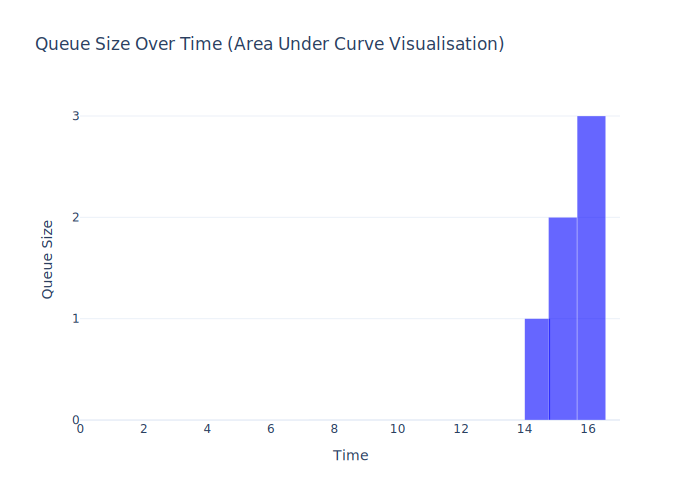

In [6]:
# Calculate durations (bar widths)
durations = [time[i+1] - time[i] for i in range(len(time)-1)]

# Create bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    x=time[:-1],  # Bar positions (start of each interval)
    y=queue[:-1],  # Queue sizes
    width=durations,  # Bar widths = time intervals
    marker={'color': 'blue', 'opacity': 0.6},
    name='Queue Size'
))

# Update layout
fig.update_xaxes(dtick=2, range=[min(time), max(time)])
fig.update_yaxes(dtick=1)
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Queue Size',
    title='Queue Size Over Time (Area Under Curve Visualisation)',
    template='plotly_white',
    bargap=0  # Ensures bars touch, mimicking area under curve
)

fig.show()

## Example 2: Utilisation

Building on our queue example:

* There are **2 nurses** in this system.
* Five patients arrive during the observation period - 2 at the start, and 3 near the end.
* **Patients A and B** are seen immediately, and each has a long consultation.
* **Patients C, D, and E** arrive and wait in the queue since no nurses are available, and are still waiting at the end of the observation period.

| Time | Event | Patients in system | Nurses busy | Queue size |
| - | - | - | - | - |
| 0.0 | Clinic opens |0 | 0 | 0 |
| 1.2 | Patient A arrives, sees nurse for 19 | 1 | 1 | 0 |
| 2.3 | Patient B arrives, sees nurse for 20 | 2 | 2 | 0 |
| 14.4 | Patient C arrives, waits for nurse | 3 | 2 | 1 |
| 15.2 | Patient D arrives, waits for nurse | 4 | 2 | 2 |
| 16.1 | Patient E arrives, waits for nurse | 5 | 2 | 3 |
| 17.0 | Simulation ends, three patients waiting still | 5 | 2 | 3 |

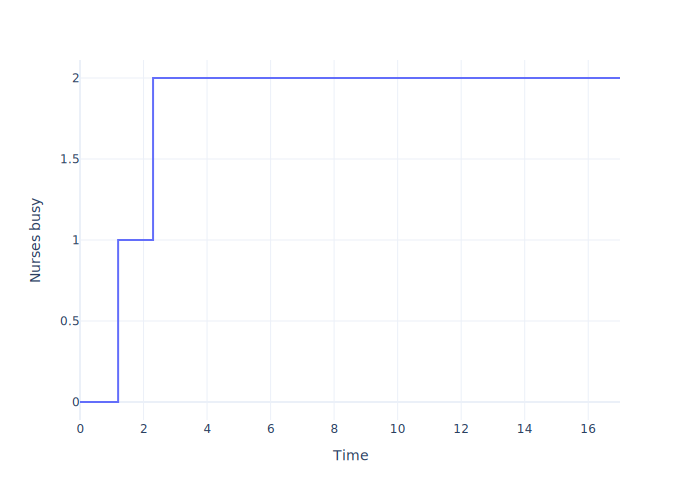

In [7]:
# Time stamps and number of nurses in use
time = [0.0, 1.2, 2.3, 14.4, 15.2, 16.1, 17.0]
nurse_in_use = [0, 1, 2, 2, 2, 2, 2]

fig1 = px.line(x=time, y=nurse_in_use)
fig1.update_traces(mode='lines', line_shape='hv')
fig1.update_xaxes(dtick=2)
fig1.update_yaxes(dtick=0.5)
fig1.update_layout(
    xaxis_title='Time',
    yaxis_title='Nurses busy',
    template='plotly_white')
fig1.show()

The utilisation of the nurses will depend on how many are busy at each point in time.

* When **no nurses** are busy, utilisation is **0.0** (i.e. 0%).
* When **one nurse** is busy, utilisation is **0.5** (i.e. 50%).
* When **two nurses** are busy, utilisation is **1.0** (i.e. 100%).

We can convert this example to utilisation...

Utilisation: [0.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]


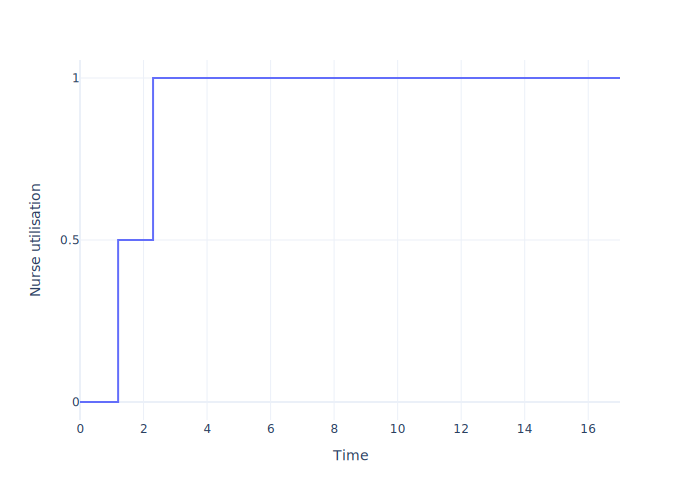

In [8]:
total_nurses = 2

# Calculate utilisation at each timepoint
utilisation = [x/total_nurses for x in nurse_in_use]
print(f'Utilisation: {utilisation}')

fig2 = px.line(x=time, y=utilisation)
fig2.update_traces(mode='lines', line_shape='hv')
fig2.update_xaxes(dtick=2)
fig2.update_yaxes(dtick=0.5)
fig2.update_layout(
    xaxis_title='Time',
    yaxis_title='Nurse utilisation',
    template='plotly_white')
fig2.show()

In this scenario, we'd expect to see an average utilisation close to 1, as there was full utilisation for most of the observation period.

### Simple average

#### Formula for simple average utilisation

$$
\text{Simple Average} = \frac{\sum (\text{Utilisation})}{\text{Number of Intervals}}
$$

#### Applying values:

$$
= \frac{0 + 0.5 + 1 + 1 + 1 + 1 + 1}{7} = 0.7857
$$


In [9]:
simple_avg = sum(utilisation) / len(utilisation)
print(f'Simple Average Utilisation: {simple_avg}')

Simple Average Utilisation: 0.7857142857142857


### Time-weighted average

#### Formula for time-weighted utilisation

$$
\text{Time-Weighted Average} = \frac{\sum (\text{Utilisation} \times \text{Time Duration})}{\text{Total Time}}
$$

#### Applying values:

$$
= \frac{(0 \times 1.2) + (0.5 \times 1.1) + (1 \times 14.7)}{17.0}
$$

$$
= \frac{0 + 0.55 + 14.7}{17.0} \approx 0.897
$$

In [10]:
weighted_sum = sum(
    utilisation[i] * (time[i+1] - time[i]) for i in range(len(time)-1)
)

# Total time duration
total_time = time[-1] - time[0]

time_weighted_avg = weighted_sum / total_time
print(f'Time-Weighted Average Utilisation: {time_weighted_avg}')

Time-Weighted Average Utilisation: 0.8970588235294119


When calculating the time-weighted average, we indeed observe a higher average utilisation, better reflecting the reality of utilisation during the observation period.

### Relating this back to the model code

In `model.py`, the simulation records resource usage as:

```{python}
# Add "area under curve" of resources in use
# self.count is the number of resources in use
self.area_resource_busy.append(self.count * time_since_last_event)
```

This is later used to calculate the time-weighted average utilisation:

```{python}
'mean_nurse_utilisation_tw': (
     model.nurse.area_resource_busy /
     (self.param.number_of_nurses *
      self.param.data_collection_period))
```

The calculation for time-weighted average utilisation in our example above was:

$$
\text{Time-Weighted Average} = \frac{\sum (\text{Utilisation} \times \text{Time Duration})}{\text{Total Time}}
$$

This is equivalent to the calculation in the code:

$$
\text{Time-Weighted Average} = \frac{\sum (\text{Nurses in use} \times \text{Time Duration})}{\text{Total Available Nurse Time}}
$$

Both formulas give the same result because they are measuring the **proportion of time nurses were used relative to the total available nurse time**. One formula does it by calculating the utilisation fraction and the other does it directly by calculating nurse time.

Remember - we are calculating area under the curve - and both are equivalent...

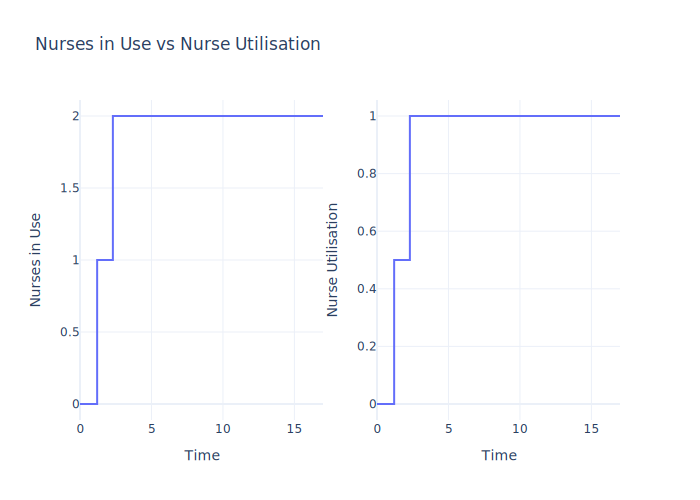

In [11]:
# Create a subplot (side by side)
fig = make_subplots(rows=1, cols=2)

# Add fig1 and fig2 to the subplot
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig2['data'][0], row=1, col=2)

# Update layout
fig.update_layout(
    template='plotly_white',
    title='Nurses in Use vs Nurse Utilisation',
    showlegend=False
)

# Edit axis labels
fig['layout']['xaxis']['title']='Time'
fig['layout']['xaxis2']['title']='Time'
fig['layout']['yaxis']['title']='Nurses in Use'
fig['layout']['yaxis2']['title']='Nurse Utilisation'


fig.show()

### Demonstrating equivalence

If we don't multiply by the total number of nurses and simply divide by the total time, like this:

$$
\text{Time-Weighted Average} = \frac{\sum (\text{Nurses in use} \times \text{Time Duration})}{\text{Total Time}}
$$

We would be calculating the time-weighted **average number of nurses in use** over time, rather than nurse utilisation.

To correctly calculate utilisation, we need to divide by the total available nurse time (i.e., total nurses multiplied by the total time). This ensures that we measure how efficiently the available nurses are being utilised, not just the raw number of nurses in use.

We can see this by recalculating our original data...

```
time = [0.0, 1.2, 2.3, 14.4, 15.2, 16.1, 17.0]
nurse_in_use = [0, 1, 2, 2, 2, 2, 2]
```

So time-weighted average number of nurses in use...

$$
= \frac{(0 \times 1.2) + (1 \times 1.1) + (2 \times 14.7)}{17.0}
$$

$$
= \frac{0 + 1.1 + 29.4}{17.0} = \frac{30.5}{17.0} \approx 1.794
$$

And then time-weighted average nurse utilisation, it's total available nurse time, which is `17 x 2` so 34...

$$
\frac{30.5}{34.0} \approx 0.897
$$

And you can see this matches the calculated utilisation above.

## Compare utilisation metrics in the model

There are three utilisation metrics in the model.

### Run results `mean_nurse_utilisation`

When nurse are seized, recorded sampled consultation time in `model.nurse_time_used`. At end of simulation, utilisation is calculated as:

$$
\text{mean\_nurse\_utilisation} = \frac{\text{model.nurse\_time\_used}}{\text{param.number\_of\_nurses} \times \text{param.data\_collection\_period}}
$$

This requires some corrections:

* When nurse time is less than the remaining simulation time, and;
* When consultations overlap between the warm-up and data collection periods.

### Run results `mean_nurse_utilisation_tw`

Nurses are set up using `MonitoredResource`. Every time a nurse is seized or released, the "area under the curve" for resources busy is updated (see `time_weighted_averages.ipynb` for more detailed explanation of how this method works).

```
self.area_resource_busy.append(self.count * time_since_last_event)
```

At the end of the simulation, utilisation is calculated as:

$$
\text{mean\_nurse\_utilisation\_tw} = \frac{\text{model.nurse.area\_resource\_busy}}{\text{param.number\_of\_nurses} \times \text{param.data\_collection\_period}}
$$

### Interval audit `utilisation`

At specified intervals (e.g. once an hour), the current utilisation is calculated from:

```
self.nurse.count / self.nurse.capacity
```

This is not used to calculated overall mean utilisation (for reasons given below).

### Comparison of methods

| Metric | Pros ✅ | Cons 🟥 |
| - | - | - |
| Run results `mean_nurse_utilisation` | Easy to understand. | Requires correction for when time with nurse is less than remaining simulation time - `min(patient.time_with_nurse, remaining_time)`.<br><br>Requires correction for consultations that overlap the warm up and data collection periods, as these are otherwise excluded from the recorded nurse time used. |
| Run results `mean_nurse_utilisation_tw` | Doesn't require correction for overlap between warm-up and data collection period.<br><br>Could add other metrics (e.g. max queue, number of times queue exceeds X length) using `MonitoredResource`. | Requires correction for when time with nurse is less than remaining simulation time (by calling `update_time_weighted_stats()` at the end of the simulation).<br><br>More complex to implement and understand the method (`time_weighted_averages.ipynb` provided to support). |
| Interval audit `utilisation` | Helpful for monitoring over time, such as when choosing appropriate warm-up length. | Less accurate for overall mean, can miss details if interval audit intervals are sparse. |

## Run time

In [12]:
# End time
end_time = datetime.now()

# Calculate elapsed time
runtime = end_time - start_time

# Display in seconds
print(f'Notebook run time: {runtime.seconds}s')

Notebook run time: 0s
